# Spectral Analysis

## Functions

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, fft, interpolate
import pywt
from skimage.metrics import structural_similarity as ssim

from importlib import reload
import dataset.data_preprocessing as dp
reload(dp)

import json
import os

# import functions as f

In [35]:
def get_data(directory, disabled):
    df_meta = dp.get_metadata_df(directory=directory, disabled=disabled)
    left, right, rate = dp.get_data_raw_cycles(directory=directory,
                                               list_joints=['Knee'],
                                               disabled=disabled)

    # df_left, df_right, rate = dp.get_data_normalized_cycles(directory=directory,
    #                                            list_joints=['Knee'],
    #                                            disabled=disabled)
    
    df_rate = pd.DataFrame(rate)
    df_rate.columns = ['Rate']
    df_meta = pd.concat([df_meta, df_rate], axis=1)
    
    # left = np.array(df_left.filter(regex='sagittal'))
    # right = np.array(df_right.filter(regex='sagittal'))
    
    return df_meta, left, right


In [36]:
def mean_centering(dictionary):
    for key, value in dictionary.items():
        mean_value = sum(value) / len(value)
        dictionary[key] = [item - mean_value for item in value]

In [37]:
def process_data(df_meta, left, right):
    left_dict = {}
    right_dict = {}

    for i in range(len(left)):
        id_patient = df_meta['id_patient'][i]
        if id_patient not in left_dict:
            left_dict[id_patient] = []
        for j in range(len(left[i])):
            left_dict[id_patient].append(left[i][j][1])
    for i in range(len(right)):
        id_patient = df_meta['id_patient'][i]
        if id_patient not in right_dict:
            right_dict[id_patient] = []
        for j in range(len(right[i])):
            right_dict[id_patient].append(right[i][j][1])

    mean_centering(left_dict)
    mean_centering(right_dict)

    df_lc_length = df_meta.groupby(['id_patient'])['Left cycle length'].sum()
    df_lc_length.name = 'Left signal length'
    df_rc_length = df_meta.groupby(['id_patient'])['Right cycle length'].sum()
    df_rc_length.name = 'Right signal length'
    df_disease = df_meta.groupby(['id_patient'])['Disease'].first()
    df_rate = df_meta.groupby(['id_patient'])['Rate'].first()
    
    df_meta_signal = pd.concat([df_disease,
                                 df_lc_length,
                                 df_rc_length,
                                 df_rate,
                                 ],
                                 axis=1)
    
    return df_meta_signal, left_dict, right_dict

In [38]:
def intp_signal(df_meta_signal, dict_right_signal, dict_left_signal):
    dict_leftsig_intp = {}
    dict_rightsig_intp = {}
    dict_ssim = {}

    for (i, left), (j, right) in zip(dict_left_signal.items(), dict_right_signal.items()):
        if len(left) < len(right):
            nleft = np.arange(len(left))
            f = interpolate.interp1d(nleft, left, kind='cubic')
            dict_leftsig_intp[i] = f(np.linspace(0, len(left) - 1, len(right)))
            dict_rightsig_intp[j] = right
        else:
            nright = np.arange(len(right))
            f = interpolate.interp1d(nright, right, kind='cubic')
            dict_rightsig_intp[j] = f(np.linspace(0, len(right) - 1, len(left)))
            dict_leftsig_intp[i] = left
        
        dict_ssim[i] = ssim(np.array(dict_leftsig_intp[i]), 
                                      np.array(dict_rightsig_intp[j]), 
                                      data_range=np.array(dict_rightsig_intp[j]).max() - np.array(dict_rightsig_intp[j]).min())
    
    df_ssim = pd.DataFrame.from_dict(dict_ssim, orient='index', columns=['SSIM'])
    df_meta_signal = pd.concat([df_meta_signal, df_ssim], axis=1)
    # df_meta_signal['Left signal length'][i] = 

    return df_meta_signal, dict_leftsig_intp, dict_rightsig_intp

In [39]:
def plot(df_patient, dict_left, dict_right):
    for index, row in df_patient.iterrows():
        id_patient = index
        disease = row['Disease Group']
        rate = row['Rate']

        x_left = np.array(dict_left[id_patient])
        x_right = np.array(dict_right[id_patient]) 

        n_left = len(x_left)
        n_right = len(x_right)

        t_right = np.arange(n_right)
        t_left = np.arange(n_left)

        # Create a 2x2 subplot grid
        fig, axs = plt.subplots(2, 4, figsize=(20, 6))

        # Plot time domain for left leg
        axs[0, 0].plot(t_left, x_left)
        axs[0, 0].set_title(f'Original: Left - {id_patient} {disease}')
        axs[0, 0].set_xlabel('Time (sample)')
        axs[0, 0].set_ylabel('Knee angle (deg)')
        axs[0, 0].spines[['right', 'top']].set_visible(False)

        # Plot time domain for right leg
        axs[1, 0].plot(t_right, x_right)
        axs[1, 0].set_title(f'Original: Right - {id_patient} {disease}')
        axs[1, 0].set_xlabel('Time (sample)')
        axs[1, 0].set_ylabel('Knee angle (deg)')
        axs[1, 0].spines[['right', 'top']].set_visible(False)

        # Compute FFT
        x_left_fft = fft.fft(x_left)
        x_right_fft = fft.fft(x_right)

        ts = 1.0 / rate
        f_left_fft = fft.fftfreq(n_left, ts)
        f_right_fft = fft.fftfreq(n_right, ts)

        # Plot frequency domain for left leg
        axs[0, 1].stem(f_left_fft[:n_left//2],
                       np.abs(x_left_fft)[:n_left//2],
                       linefmt=':',
                       markerfmt='o',
                       basefmt=' ')
        axs[0, 1].set_title(f'FFT: Left - {id_patient} - {disease}')
        axs[0, 1].set_xlabel('Frequency (Hz)')
        axs[0, 1].set_ylabel('Magnitude')
        axs[0, 1].set_xlim(left=-0.5, right=5.5, auto=True)
        axs[0, 1].spines[['right', 'top']].set_visible(False)

        # Plot frequency domain for right leg
        axs[1, 1].stem(f_right_fft[:n_right//2],
                       np.abs(x_right_fft)[:n_right//2],
                       linefmt=':',
                       markerfmt='o',
                       basefmt=' ')
        axs[1, 1].set_title(f'FFT: Right - {id_patient} {disease}')
        axs[1, 1].set_xlabel('Frequency (Hz)')
        axs[1, 1].set_ylabel('Magnitude')
        axs[1, 1].set_xlim(left=-0.5, right=5.5, auto=True)
        axs[1, 1].spines[['right', 'top']].set_visible(False)
        # print(f_right_fft)

        # Compute CWT
        wavelet = 'gaus1'
        # freq = np.array([1, 2, 3, 4, 5, 6]) / rate
        # scale= pywt.frequency2scale(wavelet, freq)
        # print(scale)
        scale = np.arange(1, 64)
        coefficients_left, frequencies_left = pywt.cwt(x_left, scale, wavelet, sampling_period=ts)
        coefficients_right, frequencies_right = pywt.cwt(x_right, scale, wavelet, sampling_period=ts)
        # print(frequencies_left)
        # print(frequencies_right)

        # # Plot scalogram for left leg
        im = axs[0, 2].imshow(np.abs(coefficients_left) ** 2,
                         aspect='auto',
                         extent=[0, n_left, frequencies_left[-1], frequencies_left[0]],
                         cmap='jet')
        axs[0, 2].set_title(f'Wavelet: Left - {id_patient} {disease}')
        axs[0, 2].set_xlabel('Time (sample)')
        axs[0, 2].set_ylabel('Frequency (Hz)')
        # axs[0, 2].set_ylim(bottom=0.15)
        axs[0, 2].spines[['top']].set_visible(False)
        plt.colorbar(im, ax=axs[0, 2], label='Power')

        # Plot scalogram for right leg
        im = axs[1, 2].imshow(np.abs(coefficients_right) ** 2,
                         aspect='auto',
                         extent=[0, n_right, frequencies_right[-1], frequencies_right[0]],
                         cmap='jet')
        axs[1, 2].set_title(f'Wavelet: Right - {id_patient} {disease}')
        axs[1, 2].set_xlabel('Time (sample)')
        axs[1, 2].set_ylabel('Frequency (Hz)')
        # axs[1, 2].set_ylim(bottom=0.15)
        axs[1, 2].spines[['top']].set_visible(False)
        plt.colorbar(im, ax=axs[1, 2], label='Power')        

        ## Spectogram
        f, t, spectr = signal.stft(x_left, fs=rate, window='hann', nperseg=100, noverlap=50)
        cycle = t * rate
        im = axs[0, 3].pcolormesh(cycle, f, np.abs(spectr), shading='gouraud')
        axs[0, 3].set_title(f'STFT: Left - {id_patient} {disease}')
        axs[0, 3].set_xlabel('Time (sample)')
        axs[0, 3].set_ylabel('Frequency (Hz)')
        axs[0, 3].set_ylim(bottom=0, top=3)
        axs[0, 3].spines[['right', 'top']].set_visible(False)
        plt.colorbar(im, ax=axs[0, 3], label='Power/Frequency (dB/Hz)')

        f, t, spectr = signal.stft(x_right, fs=rate, window='hann', nperseg=100, noverlap=50)
        cycle = t * rate
        im = axs[1, 3].pcolormesh(cycle, f, np.abs(spectr), shading='gouraud')
        axs[1, 3].set_title(f'STFT: Right - {id_patient} {disease}')
        axs[1, 3].set_xlabel('Time (sample))')
        axs[1, 3].set_ylabel('Frequency (Hz)')
        axs[1, 3].set_ylim(bottom=0, top=3)
        axs[1, 3].spines[['right', 'top']].set_visible(False)
        plt.colorbar(im, ax=axs[1, 3], label='Power/Frequency (dB/Hz)')

        plt.tight_layout()
        plt.show()

In [40]:
def export_img(df_patient, dict_left, dict_right):
    for index, row in df_patient.iterrows():
        id_patient = index
        disease = row['Disease Group']
        rate = row['Rate']
        dir = f"dataset/{id_patient}"
        os.makedirs(dir, exist_ok=True)
        
        x_left = np.array(dict_left[id_patient])
        x_right = np.array(dict_right[id_patient]) 

        n_left = len(x_left)
        n_right = len(x_right)

        t_right = np.arange(n_right)
        t_left = np.arange(n_left)

        # Plot time domain for left leg
        fig1, ax1 = plt.subplots()
        ax1.plot(t_left, x_left)
        ax1.set_title(f'Original: Left - {id_patient} - {disease}')
        ax1.set_xlabel('Time (sample)')
        ax1.set_ylabel('Knee angle (deg)')
        ax1.spines[['right', 'top']].set_visible(False)
        fig1.savefig(dir+'/'+f'ori-left-{id_patient}-{disease}.jpg', format='jpg')
        plt.close(fig1)
        # Plot time domain for right leg
        fig2, ax2 = plt.subplots()
        ax2.plot(t_right, x_right)
        ax2.set_title(f'Original: Right - {id_patient} - {disease}')
        ax2.set_xlabel('Time (sample)')
        ax2.set_ylabel('Knee angle (deg)')
        ax2.spines[['right', 'top']].set_visible(False)
        fig2.savefig(dir+'/'+f'ori-right-{id_patient}-{disease}.jpg', format='jpg')
        plt.close(fig2)

        # Compute FFT
        x_left_fft = fft.fft(x_left)
        x_right_fft = fft.fft(x_right)
        ts = 1.0 / rate
        f_left_fft = fft.fftfreq(n_left, ts)
        f_right_fft = fft.fftfreq(n_right, ts)

        # Plot frequency domain for left leg
        fig3, ax3 = plt.subplots()
        ax3.stem(f_left_fft[:n_left//2],
                       np.abs(x_left_fft)[:n_left//2],
                       linefmt=':',
                       markerfmt='o',
                       basefmt=' ')
        ax3.set_title(f'FFT: Left - {id_patient} - {disease}')
        ax3.set_xlabel('Frequency (Hz)')
        ax3.set_ylabel('Magnitude')
        ax3.set_xlim(left=-0.5, right=5.5, auto=True)
        ax3.spines[['right', 'top']].set_visible(False)
        fig3.savefig(dir+'/'+f'fft-left-{id_patient}-{disease}.jpg', format='jpg')
        plt.close(fig3)
        # Plot frequency domain for right leg
        fig4, ax4 = plt.subplots()
        ax4.stem(f_right_fft[:n_right//2],
                       np.abs(x_right_fft)[:n_right//2],
                       linefmt=':',
                       markerfmt='o',
                       basefmt=' ')
        ax4.set_title(f'FFT: Right - {id_patient} - {disease}')
        ax4.set_xlabel('Frequency (Hz)')
        ax4.set_ylabel('Magnitude')
        ax4.set_xlim(left=-0.5, right=5.5, auto=True)
        ax4.spines[['right', 'top']].set_visible(False)
        fig4.savefig(dir+'/'+f'fft-right-{id_patient}-{disease}.jpg', format='jpg')
        plt.close(fig4)
        # Compute CWT
        wavelet = 'gaus1'
        # freq = np.array([1, 2, 3, 4, 5, 6]) / rate
        # scale= pywt.frequency2scale(wavelet, freq)
        # print(scale)
        scale = np.arange(1, 64)
        coefficients_left, frequencies_left = pywt.cwt(x_left, scale, wavelet, sampling_period=ts)
        coefficients_right, frequencies_right = pywt.cwt(x_right, scale, wavelet, sampling_period=ts)
        # print(frequencies_left)
        # print(frequencies_right)

        # # Plot scalogram for left leg
        fig5, ax5 = plt.subplots()
        im = ax5.imshow(np.abs(coefficients_left) ** 2,
                         aspect='auto',
                         extent=[0, n_left, frequencies_left[-1], frequencies_left[0]],
                         cmap='jet')
        ax5.set_title(f'Wavelet: Left - {id_patient} - {disease}')
        ax5.set_xlabel('Time (sample)')
        ax5.set_ylabel('Frequency (Hz)')
        # ax5.set_ylim(bottom=0.15)
        ax5.spines[['top']].set_visible(False)
        plt.colorbar(im, ax=ax5, label='Power')
        fig5.savefig(dir+'/'+f'wvlt-left-{id_patient}-{disease}.jpg', format='jpg')
        plt.close(fig5)
        # Plot scalogram for right leg
        fig6, ax6 = plt.subplots()
        im = ax6.imshow(np.abs(coefficients_right) ** 2,
                         aspect='auto',
                         extent=[0, n_right, frequencies_right[-1], frequencies_right[0]],
                         cmap='jet')
        ax6.set_title(f'Wavelet: Right - {id_patient} - {disease}')
        ax6.set_xlabel('Time (sample)')
        ax6.set_ylabel('Frequency (Hz)')
        # ax6.set_ylim(bottom=0.15)
        ax6.spines[['top']].set_visible(False)
        plt.colorbar(im, ax=ax6, label='Power')        
        fig6.savefig(dir+'/'+f'wvlt-right-{id_patient}-{disease}.jpg', format='jpg')
        plt.close(fig6)

        ## Spectogram
        f, t, spectr = signal.stft(x_left, fs=rate, window='hann', nperseg=100, noverlap=50)
        cycle = t * rate
        fig7, ax7 = plt.subplots()
        im = ax7.pcolormesh(cycle, f, np.abs(spectr), shading='gouraud')
        ax7.set_title(f'STFT: Left - {id_patient} - {disease}')
        ax7.set_xlabel('Time (sample)')
        ax7.set_ylabel('Frequency (Hz)')
        ax7.set_ylim(bottom=0, top=3)
        ax7.spines[['right', 'top']].set_visible(False)
        plt.colorbar(im, ax=ax7, label='Power/Frequency (dB/Hz)')
        fig7.savefig(dir+'/'+f'stft-left-{id_patient}-{disease}.jpg', format='jpg')
        plt.close(fig7)

        f, t, spectr = signal.stft(x_right, fs=rate, window='hann', nperseg=100, noverlap=50)
        cycle = t * rate
        fig8, ax8 = plt.subplots()
        im = ax8.pcolormesh(cycle, f, np.abs(spectr), shading='gouraud')
        ax8.set_title(f'STFT: Right - {id_patient} - {disease}')
        ax8.set_xlabel('Time (sample))')
        ax8.set_ylabel('Frequency (Hz)')
        ax8.set_ylim(bottom=0, top=3)
        ax8.spines[['right', 'top']].set_visible(False)
        plt.colorbar(im, ax=ax8, label='Power/Frequency (dB/Hz)')
        fig8.savefig(dir+'/'+f'stft-right-{id_patient}-{disease}.jpg', format='jpg')
        plt.close(fig8)

In [41]:
def trend(df_patient, dict_left, dict_right, top):
    top_freq_df = pd.DataFrame(columns=['id_patient',
                                        'top freq left',
                                        'top mag left',
                                        'top freq right',
                                        'top mag right'])

    for index, row in df_patient.iterrows():
        id_patient = index
        rate = row['Rate']

        x_left = np.array(dict_left[id_patient])
        x_right = np.array(dict_right[id_patient])

        # Compute FFT
        x_left_fft = fft.fft(x_left)
        x_right_fft = fft.fft(x_right)
        n_left = len(x_left)
        n_right = len(x_right)
        ts = 1.0 / rate
        f_left_fft = fft.fftfreq(n_left, ts)
        f_right_fft = fft.fftfreq(n_right, ts)

        # Find the top 10 frequencies and magnitudes for left leg
        top_indices_left = np.argsort(np.abs(x_left_fft[:n_left//2]))[::-1][:top]
        top_frequencies_left = f_left_fft[top_indices_left]
        top_magnitudes_left = np.abs(x_left_fft[top_indices_left])

        # Find the top 10 frequencies and magnitudes for right leg
        top_indices_right = np.argsort(np.abs(x_right_fft[:n_right//2]))[::-1][:top]
        top_frequencies_right = f_right_fft[top_indices_right]
        top_magnitudes_right = np.abs(x_right_fft[top_indices_right])
       
        df = pd.DataFrame({'id_patient': id_patient,
                           'top freq left': top_frequencies_left,
                           'top mag left': top_magnitudes_left,
                           'top freq right': top_frequencies_right,
                           'top mag right': top_magnitudes_right})
        top_freq_df = pd.concat([top_freq_df, df],axis=0)

    # print(top_freq_df)
    melted_df_left = top_freq_df[['id_patient', 'top freq left', 'top mag left']].rename(columns={'top freq left': 'frequency', 'top mag left': 'magnitude'})
    melted_df_right = top_freq_df[['id_patient', 'top freq right', 'top mag right']].rename(columns={'top freq right': 'frequency', 'top mag right': 'magnitude'})
    melted_df_left['side'] = 'left'
    melted_df_right['side'] = 'right'
    melted_df = pd.concat([melted_df_left, melted_df_right])
    # print(melted_df)

    # Create the FacetGrid
    grid = sns.FacetGrid(melted_df, col='side', hue='side', palette="viridis")

    # Map the scatter plot onto the grid
    grid.map(plt.scatter, 'frequency', 'magnitude', alpha=0.7)

    # Add legend
    grid.add_legend()

    # Show the plot
    plt.show()

    # return melted_df

In [42]:
def cyc_to_sig(df_meta_cycle, left_cycle, right_cycle):
    dict_left_signal = {}
    dict_right_signal = {}

    for i, (left, right) in enumerate(zip(left_cycle, right_cycle)):
        id_patient = df_meta_cycle['id_patient'][i]
        
        dict_left_signal.setdefault(id_patient, []).extend(left.tolist())
        dict_right_signal.setdefault(id_patient, []).extend(right.tolist())

    mean_centering(dict_left_signal)
    mean_centering(dict_right_signal)
    
    df_lc_length = df_meta_cycle.groupby(['id_patient'])['Left cycle length'].sum()
    df_lc_length.name = 'Left signal length'
    df_rc_length = df_meta_cycle.groupby(['id_patient'])['Right cycle length'].sum()
    df_rc_length.name = 'Right signal length'
    df_disease = df_meta_cycle.groupby(['id_patient'])['Disease'].first()
    df_rate = df_meta_cycle.groupby(['id_patient'])['Rate'].first()

    df_meta_signal = pd.concat([df_disease,
                                 df_lc_length,
                                 df_rc_length,
                                 df_rate],
                                 axis=1)
    
    return df_meta_signal, dict_left_signal, dict_right_signal


In [43]:
def interpolate_array(src_array, target_shape):
    src_shape = src_array.shape
    x = np.linspace(0, src_shape[0], src_shape[0])
    y = np.linspace(0, src_shape[1], src_shape[1])
    new_x = np.linspace(0, src_shape[0], target_shape[0])
    new_y = np.linspace(0, src_shape[1], target_shape[1])
    interpolator = interpolate.RectBivariateSpline(x, y, src_array)
    return interpolator(new_x, new_y)

In [44]:
def intp_wavelet(df_meta_signal, dict_left_signal, dict_right_signal):
    dict_left_wav = {}
    dict_right_wav = {}
    dict_ssim = {}
    
    wavelet = 'gaus1'
    scale = np.arange(1, 64)

    for i, row in df_meta_signal.iterrows():
        rate = row['Rate']
        ts = 1.0 / rate
        
        left = np.array(dict_left_signal[i])
        right = np.array(dict_right_signal[i]) 

        coefficients_left, frequencies_left = pywt.cwt(left, scale, wavelet, sampling_period=ts)
        coefficients_right, frequencies_right = pywt.cwt(right, scale, wavelet, sampling_period=ts)

        if coefficients_left.size < coefficients_right.size:
            dict_left_wav[i] = interpolate_array(coefficients_left, coefficients_right.shape)
            dict_right_wav[i] = coefficients_right
        elif coefficients_left.size > coefficients_right.size:
            dict_left_wav[i] = coefficients_left
            dict_right_wav[i] = interpolate_array(coefficients_right, coefficients_left.shape)
        else:
            dict_left_wav[i] = coefficients_left
            dict_right_wav[i] = coefficients_right

        dict_ssim[i] = ssim(np.array(dict_left_wav[i]), np.array(dict_right_wav[i]), 
                                      data_range=np.array(dict_right_wav[i]).max() - np.array(dict_right_wav[i]).min())
    
    df_ssim = pd.DataFrame.from_dict(dict_ssim, orient='index', columns=['SSIM'])
    df_meta_signal = pd.concat([df_meta_signal, df_ssim], axis=1)

    return df_meta_signal

## Healthy Control

### Import HC data

In [45]:
# dir_HC = "dataset/Sujets sains"
# df_meta_cycle_HC, left_cycle_HC, right_cycle_HC = get_data(dir_HC, False)

# df_meta_cycle_HC.to_csv('df_meta_cycle_HC.csv')

# json_left = json.dumps(left_cycle_HC)
# with open("left_cycle_HC.json", "w") as outfile:
#     outfile.write(json_left)

# json_right = json.dumps(right_cycle_HC)
# with open("right_cycle_HC.json", "w") as outfile:
#     outfile.write(json_right)

In [46]:
# df_meta_cycle_HC = pd.read_csv("df_meta_cycle_HC.csv", index_col=0)
# with open("left_cycle_HC.json", "r") as openfile:
#     left_cycle_HC = json.load(openfile)
# with open("right_cycle_HC.json", "r") as openfile:
#     right_cycle_HC = json.load(openfile)

In [47]:
# # df_meta_signal_HC, dict_left_signal_HC, dict_right_signal_HC = cyc_to_sig(df_meta_cycle_HC, left_cycle_HC, right_cycle_HC)
# # df_metasig_HC, dict_leftsig_HC, dict_rightsig_HC = intp_signal(df_meta_signal_HC, dict_left_signal_HC, dict_right_signal_HC)
# df_meta_signal_HC, dict_left_signal_HC, dict_right_signal_HC = process_data(df_meta_cycle_HC, left_cycle_HC, right_cycle_HC)

In [48]:
# df_meta_signal_HC['Disease Group'] = "HC"
# df_meta_signal_HC.to_csv('df_meta_signal_HC.csv')

# def convert_numpy(obj):
#     if isinstance(obj, np.ndarray):
#         return obj.tolist()  # Convert numpy array to list
#     elif isinstance(obj, np.int64):
#         return int(obj)  # Convert numpy.int64 to int
#     elif isinstance(obj, dict):
#         return {convert_numpy(key): convert_numpy(value) for key, value in obj.items()}
#     elif isinstance(obj, list):
#         return [convert_numpy(element) for element in obj]
#     else:
#         return obj
    
# converted_data = convert_numpy(dict_left_signal_HC)
# json_left = json.dumps(converted_data)
# with open("dict_left_signal_HC.json", "w") as outfile:
#     outfile.write(json_left)

# converted_data = convert_numpy(dict_right_signal_HC)
# json_right = json.dumps(converted_data)
# with open("dict_right_signal_HC.json", "w") as outfile:
#     outfile.write(json_right)

In [49]:
def convert_keys_to_int(obj):
    if isinstance(obj, dict):
        return {int(key): convert_keys_to_int(value) for key, value in obj.items()}  # Convert keys to int
    elif isinstance(obj, list):
        return [convert_keys_to_int(element) for element in obj]
    else:
        return obj
    
df_meta_signal_HC = pd.read_csv("df_meta_signal_HC.csv", index_col=0)
with open("dict_left_signal_HC.json", "r") as openfile:
    loaded_data = json.load(openfile)
    dict_left_signal_HC = convert_keys_to_int(loaded_data)
with open("dict_right_signal_HC.json", "r") as openfile:
    loaded_data = json.load(openfile)
    dict_right_signal_HC = convert_keys_to_int(loaded_data)

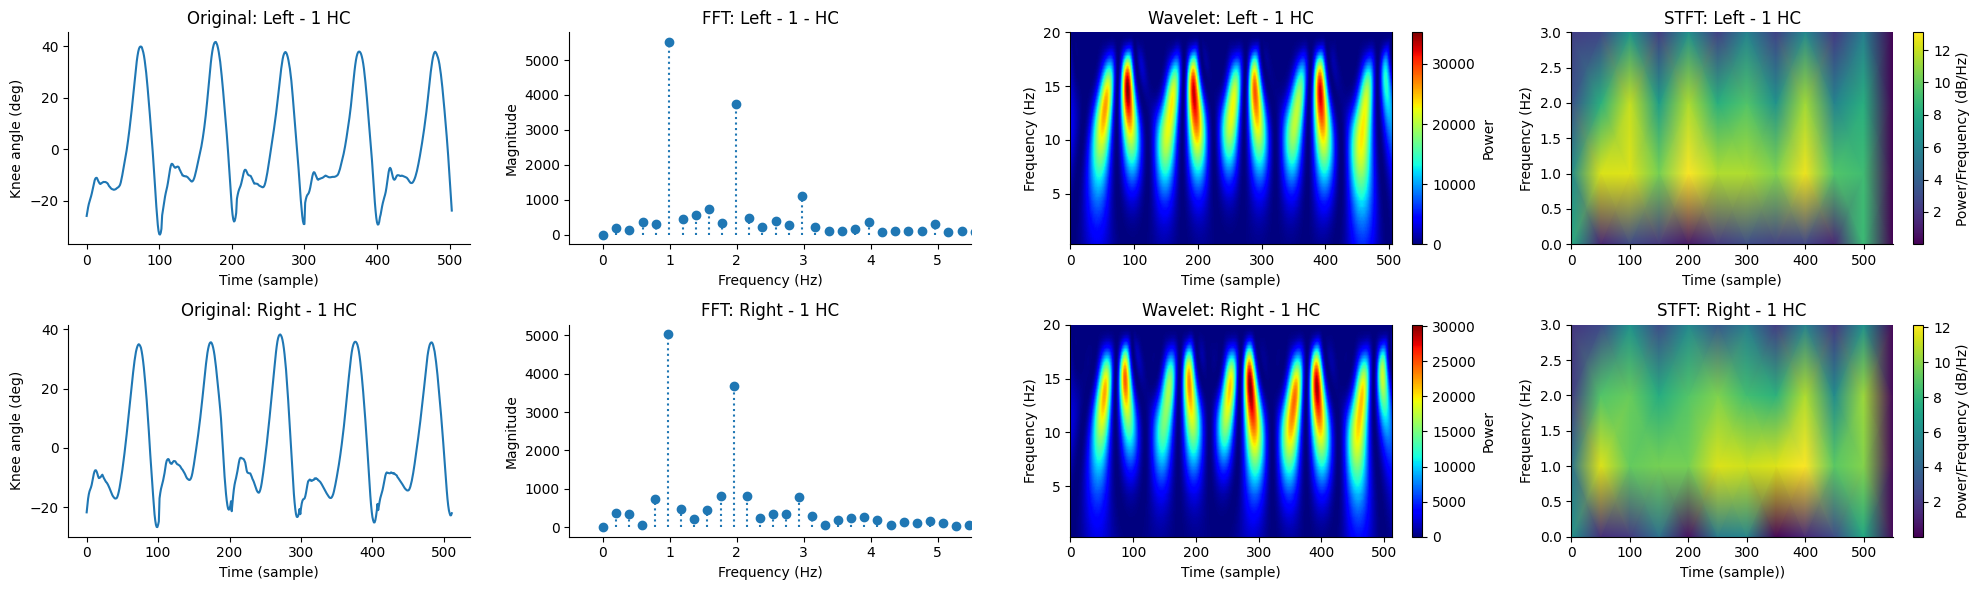

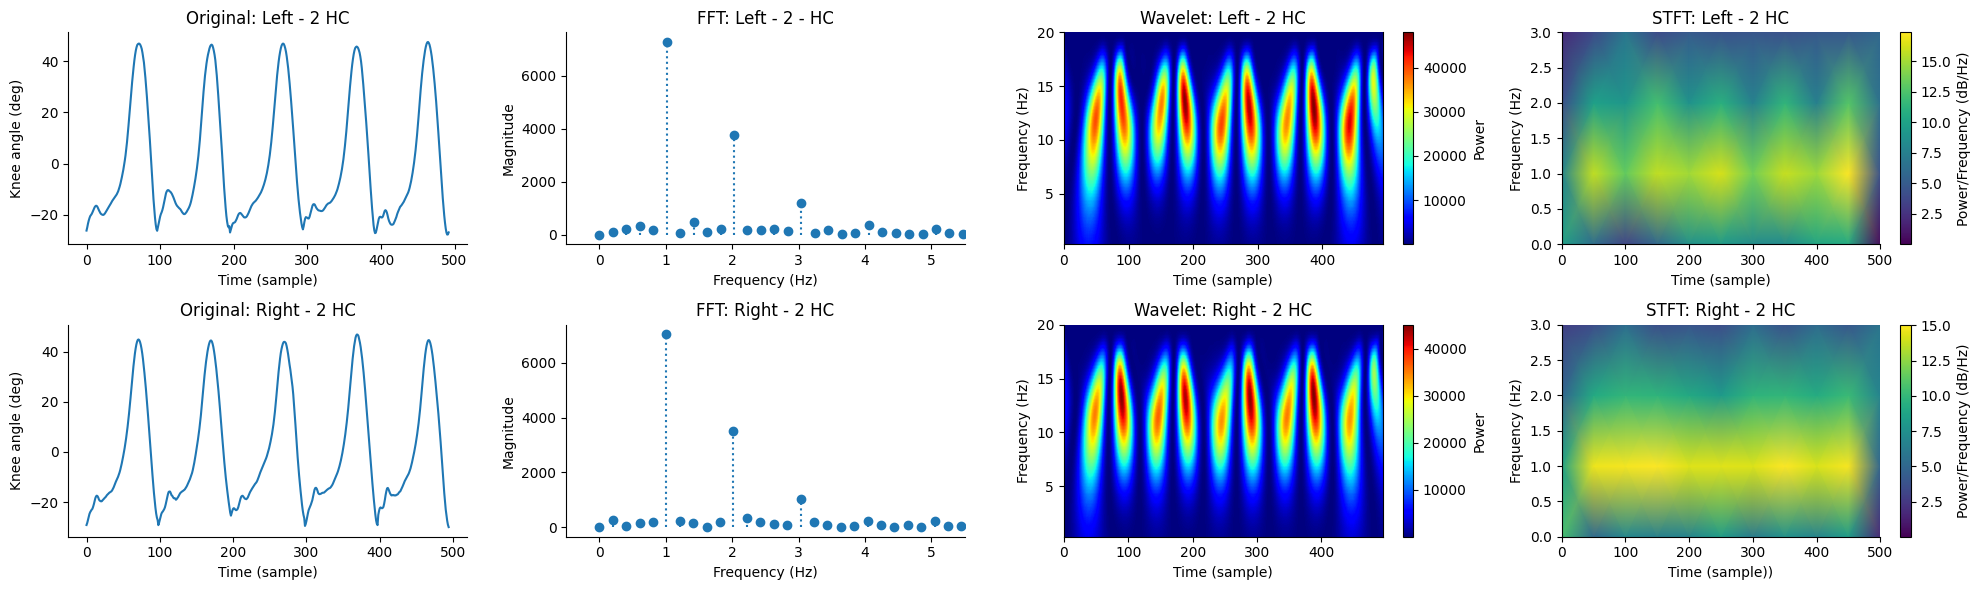

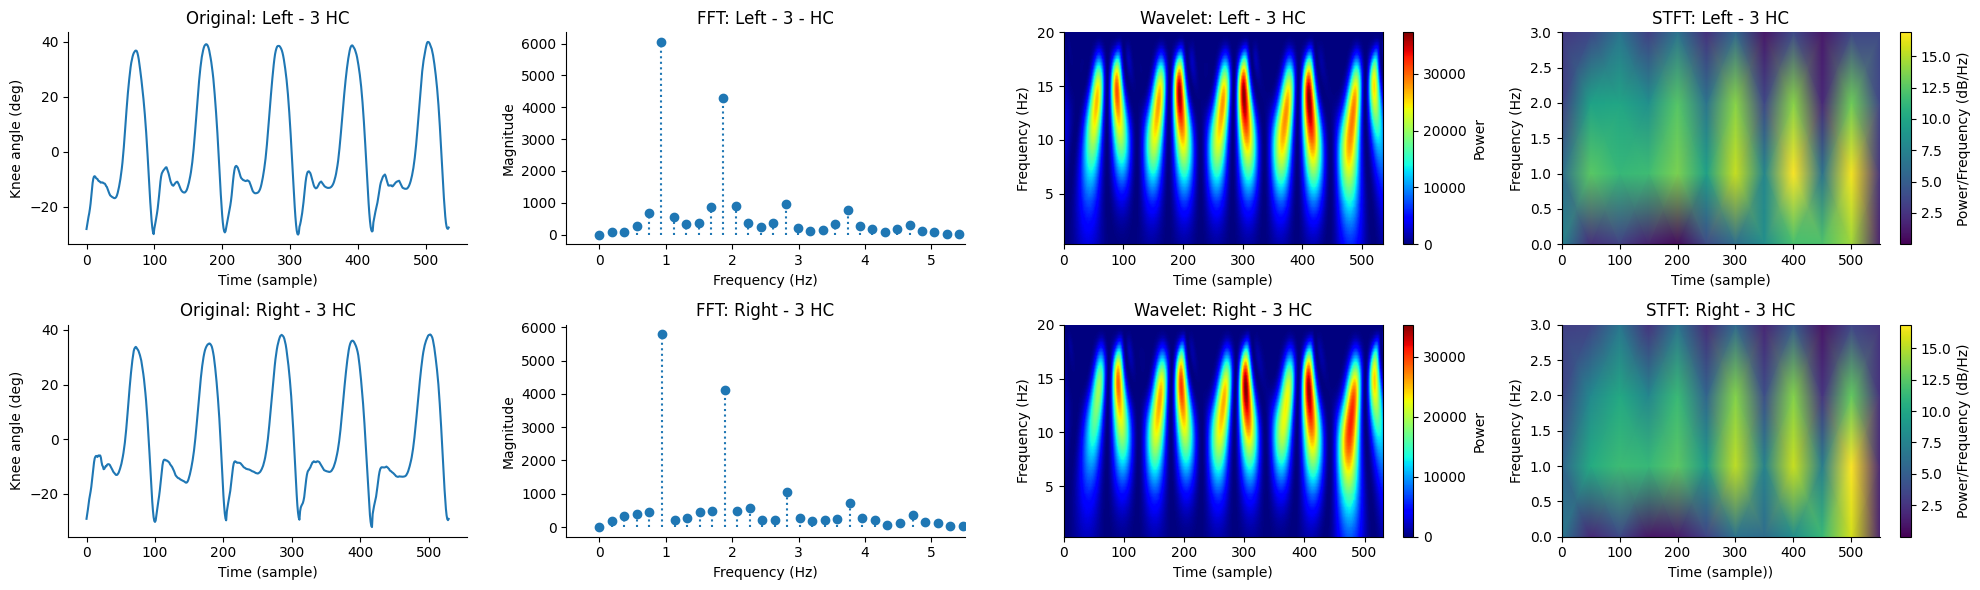

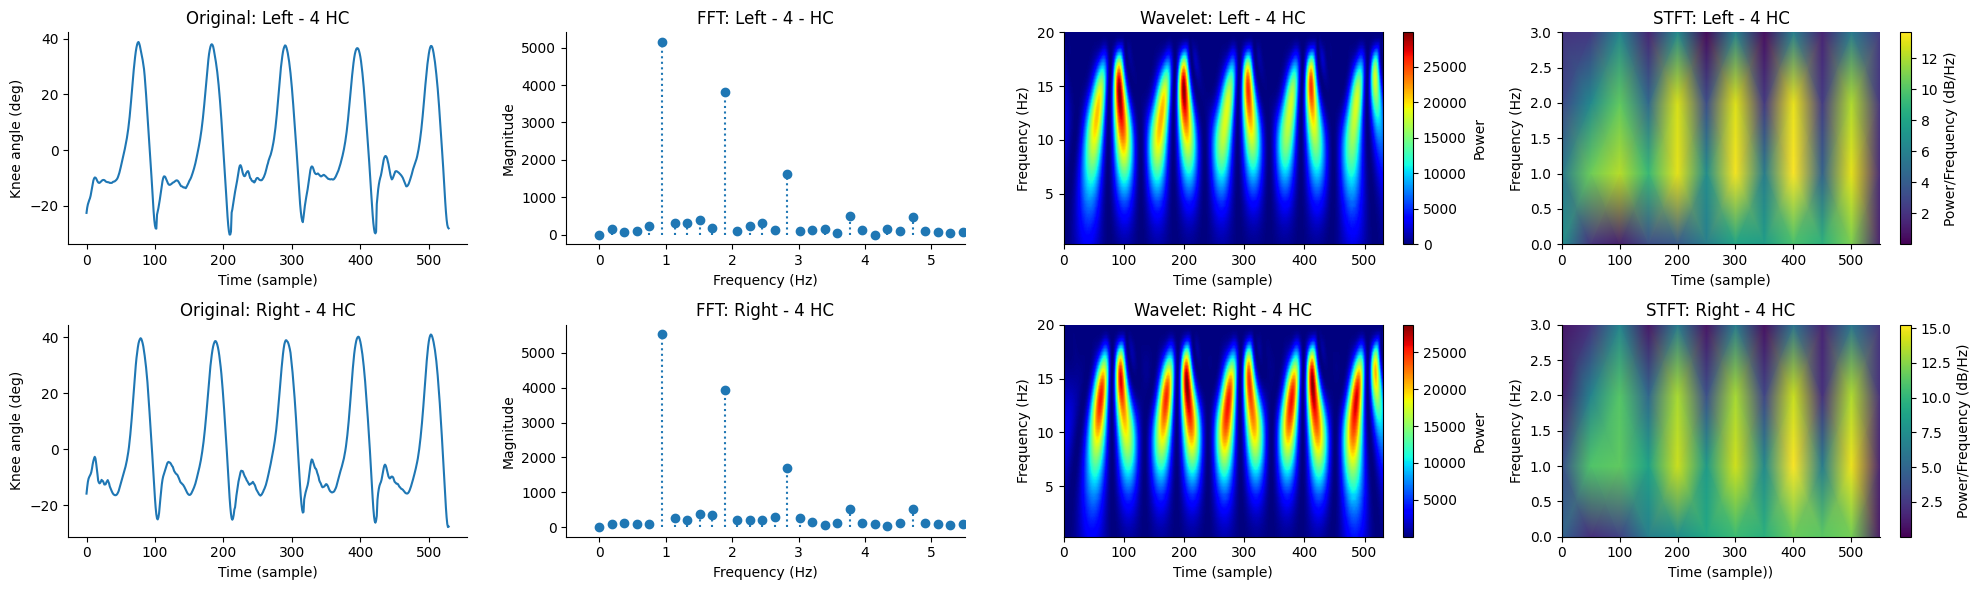

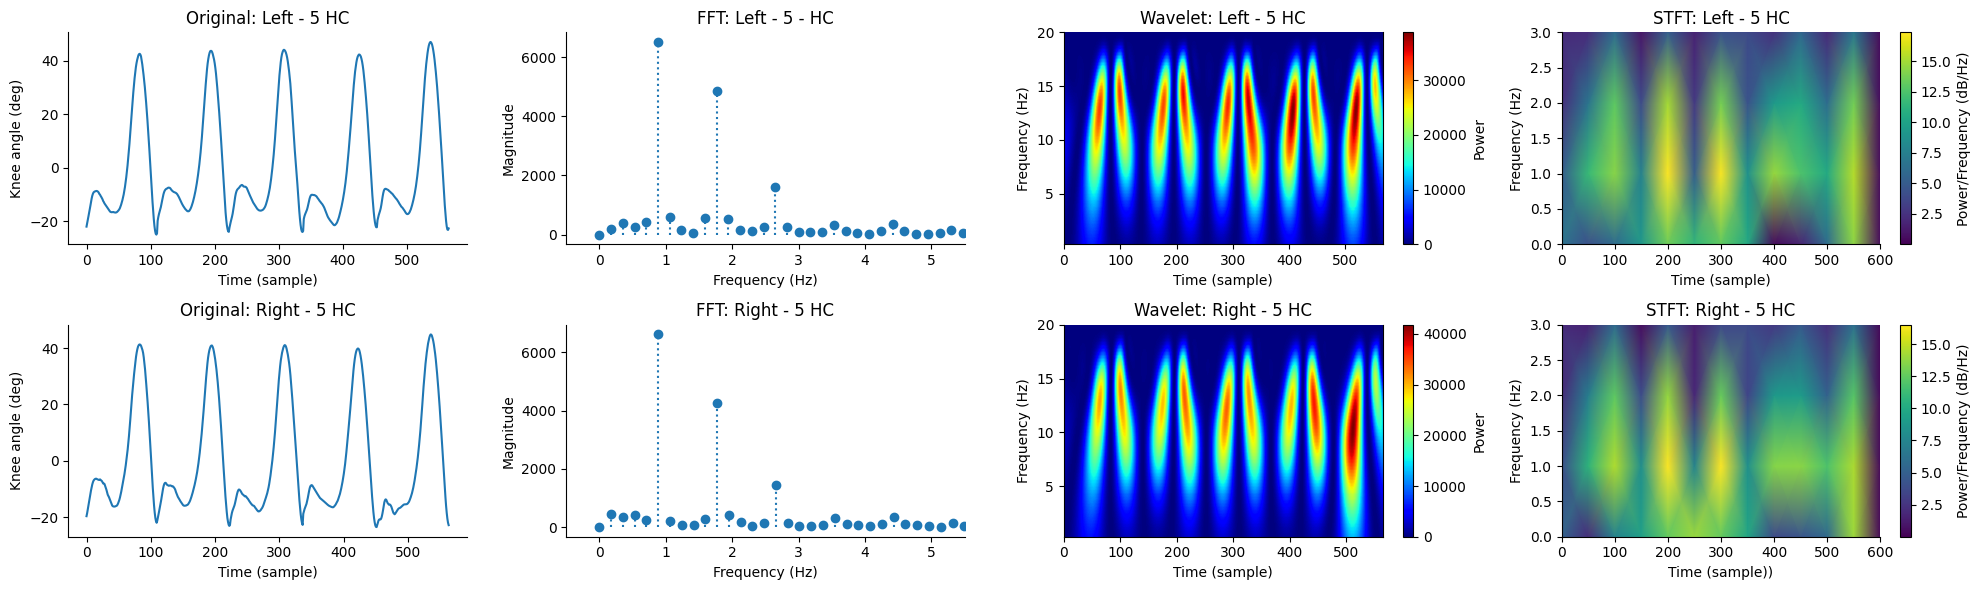

In [50]:
# df_patient_HC = df_metasig_HC[df_metasig_HC["Disease Group"] == "HC"].head(5)
# plot(df_patient=df_patient_HC, dict_left=dict_leftsig_HC, dict_right=dict_rightsig_HC)

df_patient_HC = df_meta_signal_HC[df_meta_signal_HC["Disease Group"] == "HC"].head(5)
plot(df_patient=df_patient_HC, dict_left=dict_left_signal_HC, dict_right=dict_right_signal_HC)

In [51]:
# df_patient_HC = df_meta_signal_HC[df_meta_signal_HC["Disease Group"] == "HC"]
# export_img(df_patient=df_patient_HC, dict_left=dict_left_signal_HC, dict_right=dict_right_signal_HC)

/var/folders/6y/9sn_0x3d041dsl6rwm8hpy300000gn/T/ipykernel_32318/2308066894.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_freq_df = pd.concat([top_freq_df, df],axis=0)


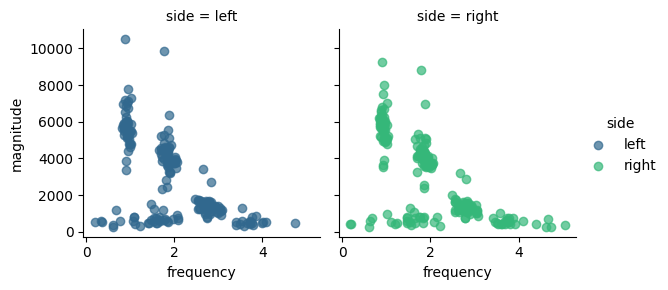

In [52]:
trend(
    df_patient=df_meta_signal_HC,
    dict_left=dict_left_signal_HC,
    dict_right=dict_right_signal_HC,
    top=4,
)

## Pathological Subjects

### Import Pathological data

In [53]:
# dir_PT = "dataset/Sujets patho"
# df_meta_cycle_PT, left_cycle_PT, right_cycle_PT = get_data(dir_PT, True)

# df_meta_cycle_PT.to_csv('df_meta_cycle_PT.csv')

# json_left = json.dumps(left_cycle_PT)
# with open("left_cycle_PT.json", "w") as outfile:
#     outfile.write(json_left)

# json_right = json.dumps(right_cycle_PT)
# with open("right_cycle_PT.json", "w") as outfile:
#     outfile.write(json_right)

In [54]:
# dir_PT = "dataset/Sujets patho 2"
# df_meta_cycle_PT_2, left_cycle_PT_2, right_cycle_PT_2 = get_data(dir_PT, True)

In [55]:
df_meta_cycle_PT = pd.read_csv("df_meta_cycle_PT.csv", index_col=0)
with open("left_cycle_PT.json", "r") as openfile:
    left_cycle_PT = json.load(openfile)
with open("right_cycle_PT.json", "r") as openfile:
    right_cycle_PT = json.load(openfile)

In [56]:
df_meta_cycle_PT['id_patient'] = df_meta_cycle_PT['id_patient'].str.replace('_', ' ')
df_meta_cycle_PT['id_patient'] = df_meta_cycle_PT['id_patient'].str.replace('1', '')

In [57]:
patient_disease = pd.read_csv("Label_disease_per_patient.csv", index_col=0)
patient_disease = patient_disease.set_index('id_patient')
patient_disease.index = patient_disease.index.str.replace('DA COSTA Rogerio', 'DA COSTA ROMAO Rogerio')
patient_disease.index = patient_disease.index.str.replace('GOUTTE Michellee', 'GOUTTE Michele')
patient_disease.index = patient_disease.index.str.replace('QIU Shouqing', 'QIU Shouyqing')

In [58]:
df_meta_signal_PT, dict_left_signal_PT, dict_right_signal_PT = process_data(df_meta_cycle_PT, left_cycle_PT, right_cycle_PT)
# df_metasig_PT, dict_leftsig_PT, dict_rightsig_PT = intp_signal(df_meta_signal_PT, dict_left_signal_PT, dict_right_signal_PT)

df_meta_signal_PT = pd.concat([df_meta_signal_PT, patient_disease], axis=1)
df_meta_signal_PT = df_meta_signal_PT.dropna()
# df_meta_signal_PT = df_meta_signal_PT.drop('Disease', axis=1)
# df_meta_signal_PT = df_meta_signal_PT.rename(columns={"Label_disease" : "Disease"}, inplace=True)

In [59]:
# id_patient_map = {name: i for i, name in enumerate(dict_left_signal_PT.keys())}
id_patient_map = {name: ''.join(part[0] for part in name.split()) for name in dict_left_signal_PT.keys()}

df_meta_signal_PT['initial_patient'] = df_meta_signal_PT.index.map(lambda x: id_patient_map.get(x))

df_metasig_PT = df_meta_signal_PT.set_index('initial_patient')
dict_leftsig_PT = {id_patient_map[name]: value for name, value in dict_left_signal_PT.items()}
dict_rightsig_PT = {id_patient_map[name]: value for name, value in dict_right_signal_PT.items()}

In [60]:
disease_map = [
    (df_metasig_PT['Label_disease'].str.contains('mip', case=False), 'Hemi'),
    (df_metasig_PT['Label_disease'].str.contains('trap', case=False), 'Tetra'),
    (df_metasig_PT['Label_disease'].str.contains('Para', case=False), 'Para'),
    (True, 'Other PT')  # Default for any other disease not matched
]

# Apply mapping rules and create new column
df_metasig_PT['Disease Group'] = np.select([condition for condition, _ in disease_map], [value for _, value in disease_map], default='Other PT')


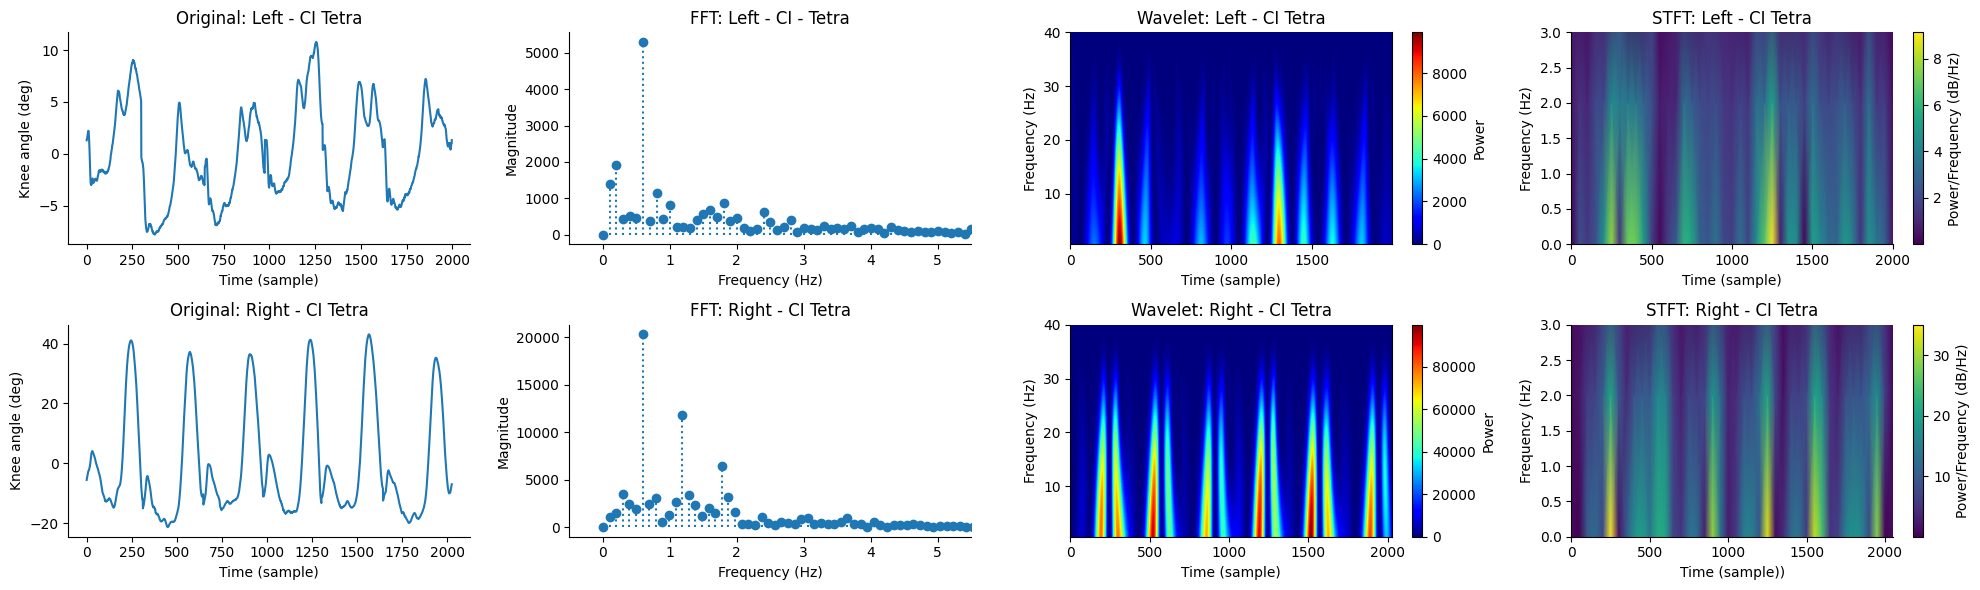

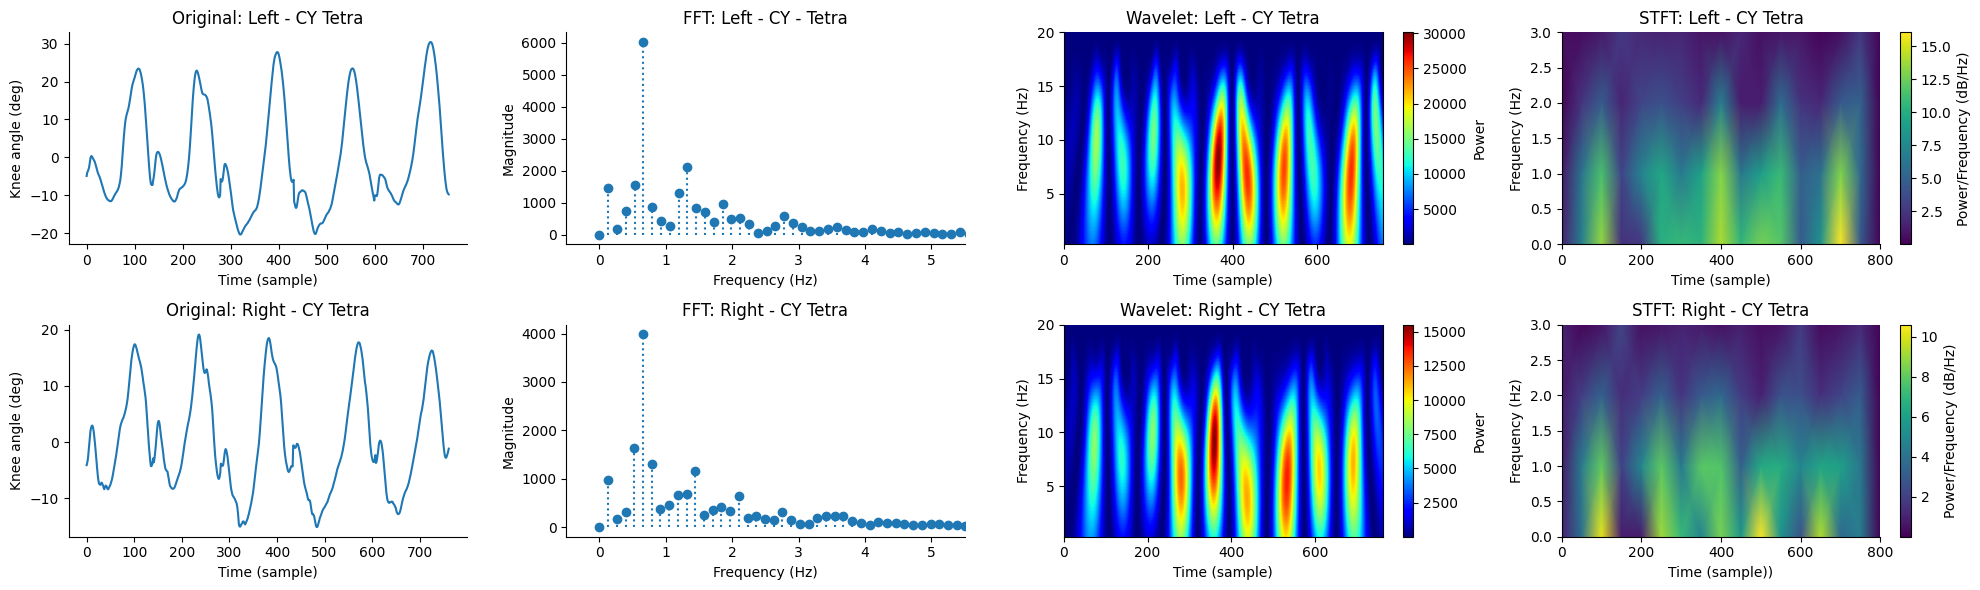

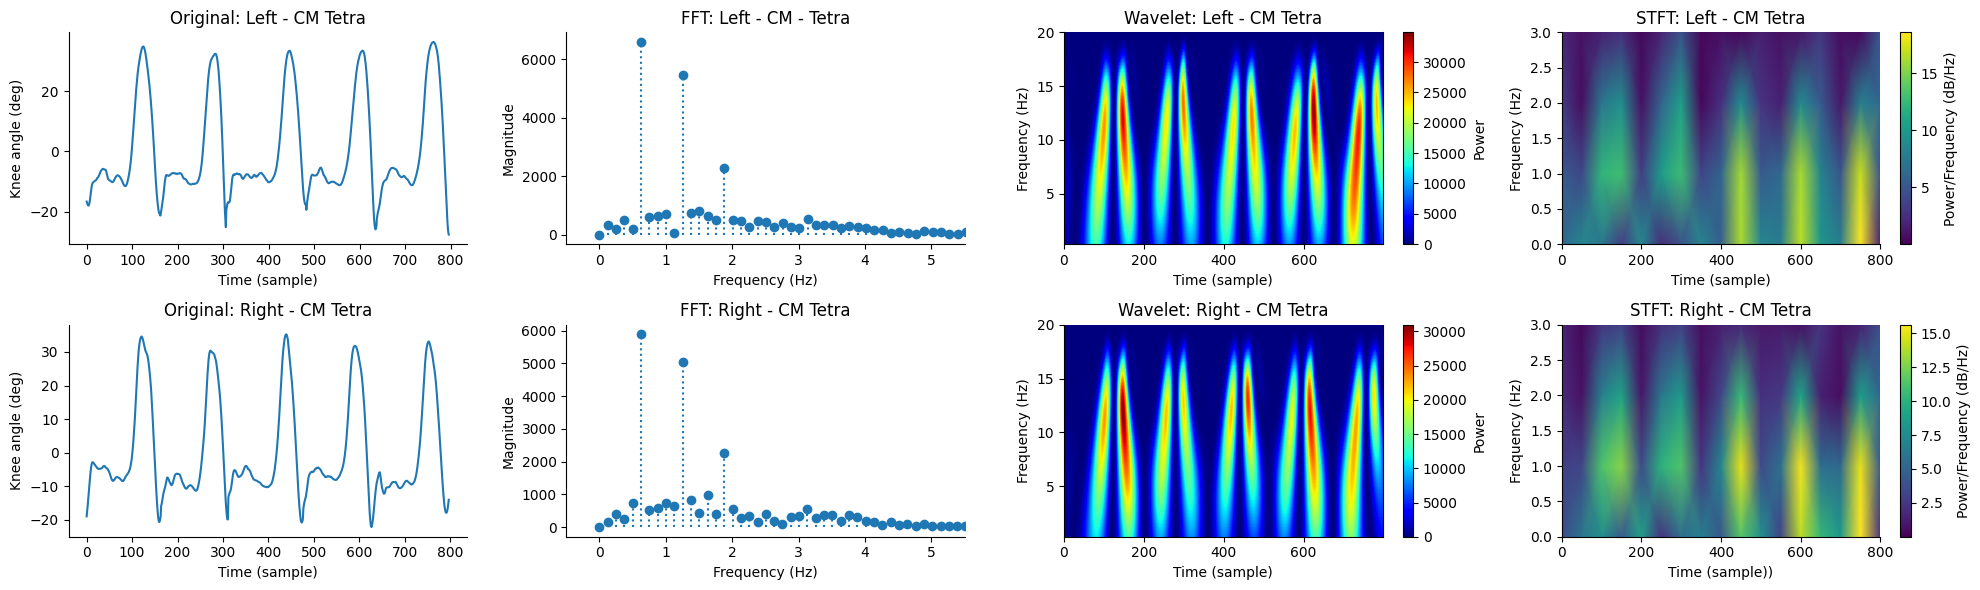

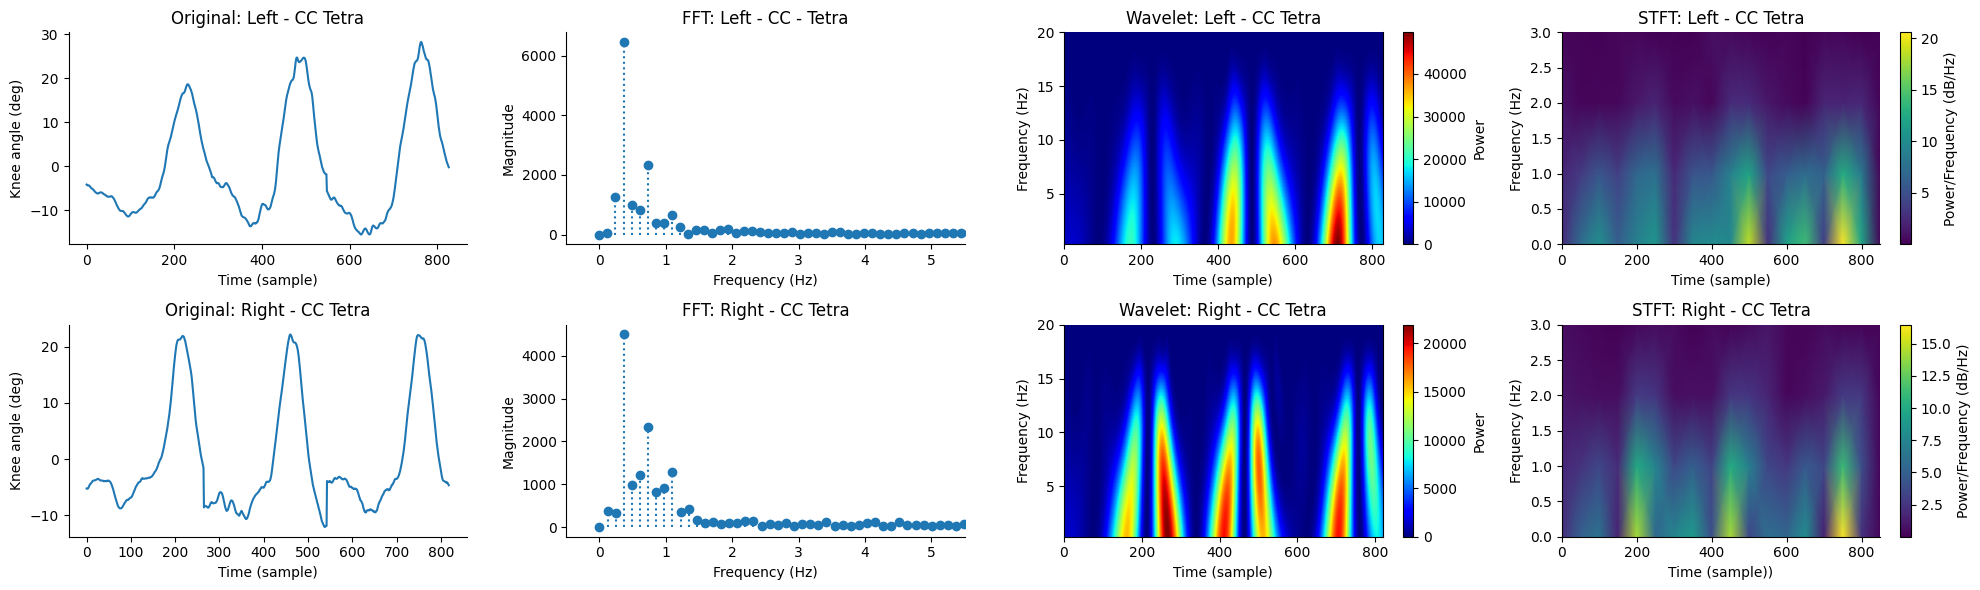

In [61]:
df_patient_PT = df_metasig_PT[df_metasig_PT["Disease Group"] == "Tetra"].head(4)
plot(df_patient=df_patient_PT, dict_left=dict_leftsig_PT, dict_right=dict_rightsig_PT)

In [62]:
# df_patient_PT = df_metasig_PT
# export_img(df_patient=df_patient_PT, dict_left=dict_leftsig_PT, dict_right=dict_rightsig_PT)

/var/folders/6y/9sn_0x3d041dsl6rwm8hpy300000gn/T/ipykernel_32318/2308066894.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_freq_df = pd.concat([top_freq_df, df],axis=0)


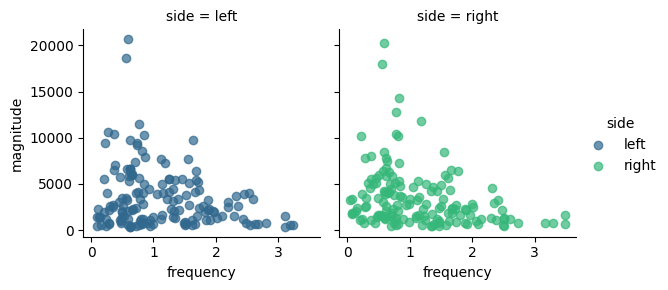

In [63]:
trend(
    df_patient=df_metasig_PT,
    dict_left=dict_leftsig_PT,
    dict_right=dict_rightsig_PT,
    top=4,
)

## Structural Similarity Index  (SSIM) between Left and Right Leg

In [64]:
df_metasig_intp_HC = intp_wavelet(df_meta_signal_HC, dict_left_signal_HC, dict_right_signal_HC)
df_metasig_intp_PT = intp_wavelet(df_metasig_PT, dict_leftsig_PT, dict_rightsig_PT)

### SSIM per Population Group

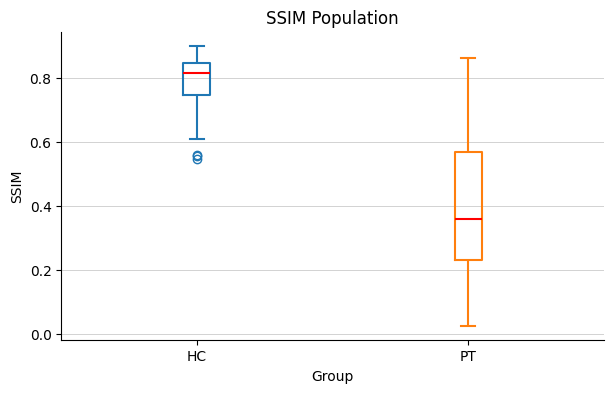

In [65]:
df_metasig_intp_HC['Group'] = 'HC'
df_metasig_intp_PT['Group'] = 'PT'
combined_df = pd.concat([df_metasig_intp_HC, df_metasig_intp_PT])
order = combined_df.groupby(['Group'])['SSIM'].median().sort_values(ascending=False).index
fig, axs = plt.subplots(figsize=(7, 4))
sns.boxplot(data=combined_df, x='Group', y='SSIM', order=order,
            width=0.1, fill=False, hue='Group',
            medianprops={"color": "r"})
axs.spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linewidth=0.4)
plt.title('SSIM Population')
plt.show()

### SSIM per Pathological Type

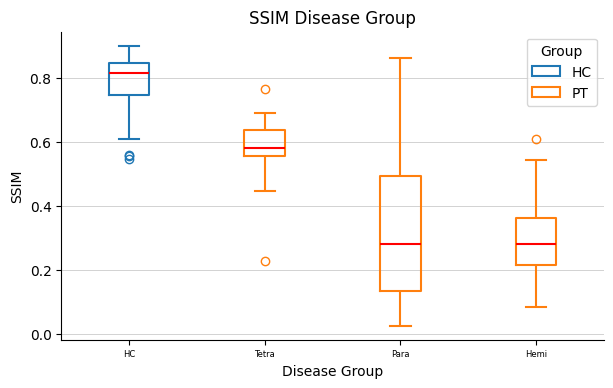

In [66]:
fig, axs = plt.subplots(figsize=(7, 4))
order = combined_df.groupby(['Disease Group'])['SSIM'].median().sort_values(ascending=False).index
sns.boxplot(data=combined_df, x='Disease Group', y='SSIM', order=order,
            width=0.3, fill=False, hue='Group',
            medianprops={"color": "r"})
axs.spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linewidth=0.4)
plt.xticks(fontsize=6)
plt.title('SSIM Disease Group')
plt.show()